In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [2]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [3]:
## 복제된 행 제거
df_train.drop_duplicates(inplace=True)

# 무조건 converted하면서 test에 없는 회사인 25096은 삭제
del_cus_id=[25096]
df_train=df_train[~df_train["customer_idx"].isin(del_cus_id)]
df_train = df_train[(df_train["business_unit"] != "CM") & (df_train["business_unit"] != "Solution")]

In [4]:
print(df_train.shape)
print(df_test.shape)

(53090, 29)
(5271, 30)


In [5]:
df_train.columns

Index(['bant_submit', 'customer_country', 'business_unit',
       'com_reg_ver_win_rate', 'customer_idx', 'customer_type', 'enterprise',
       'historical_existing_cnt', 'id_strategic_ver', 'it_strategic_ver',
       'idit_strategic_ver', 'customer_job', 'lead_desc_length',
       'inquiry_type', 'product_category', 'product_subcategory',
       'product_modelname', 'customer_country.1', 'customer_position',
       'response_corporate', 'expected_timeline', 'ver_cus', 'ver_pro',
       'ver_win_rate_x', 'ver_win_ratio_per_bu', 'business_area',
       'business_subarea', 'lead_owner', 'is_converted'],
      dtype='object')

In [6]:
df_train["is_converted"].value_counts()

is_converted
False    50875
True      2215
Name: count, dtype: int64

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53090 entries, 0 to 59297
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              53090 non-null  float64
 1   customer_country         52206 non-null  object 
 2   business_unit            53090 non-null  object 
 3   com_reg_ver_win_rate     14071 non-null  float64
 4   customer_idx             53090 non-null  int64  
 5   customer_type            14421 non-null  object 
 6   enterprise               53090 non-null  object 
 7   historical_existing_cnt  12297 non-null  float64
 8   id_strategic_ver         3328 non-null   float64
 9   it_strategic_ver         1108 non-null   float64
 10  idit_strategic_ver       4436 non-null   float64
 11  customer_job             36837 non-null  object 
 12  lead_desc_length         53090 non-null  int64  
 13  inquiry_type             52276 non-null  object 
 14  product_category         36

In [8]:
cnt=0
for i in df_test['lead_owner'].unique():
    if i not in df_train['lead_owner'].unique():
        print(i, end=" ")
        cnt+=1
print("")
print(cnt)

874 577 353 308 731 766 591 960 867 1046 316 748 1108 135 772 377 749 723 1063 892 727 1028 136 1032 427 747 379 554 327 356 1062 1055 773 777 1026 999 969 127 313 1025 320 962 907 866 963 373 733 315 750 581 573 595 931 966 922 751 735 331 983 571 736 828 1056 558 850 323 734 965 769 868 1033 562 576 587 978 336 844 347 908 1023 911 1024 752 565 496 1058 588 821 
88


In [9]:
cnt = 0
cnt2 =0
for i in range(len(df_test)):
    if df_test['lead_owner'][i] not in list(df_train['lead_owner']) :
        if df_test['customer_idx'][i] not in list(df_train['customer_idx']) :
            cnt+=1
        else :
            cnt2+=1
print(cnt, cnt2)

365 85


In [10]:
cnt=0
for i in df_train['lead_owner'].unique():
    if i not in df_test['lead_owner'].unique():
        print(i, end=" ")
        cnt+=1
print("")
print(cnt)

5 20 23 24 27 28 31 33 35 38 40 41 43 50 52 53 55 57 58 60 62 63 64 65 67 68 69 70 71 72 74 75 79 80 81 82 84 85 86 87 91 92 94 96 98 99 101 102 106 107 108 111 112 113 117 119 128 134 133 140 150 153 154 160 161 162 163 170 172 175 176 177 178 180 182 183 184 186 191 193 196 197 199 200 201 204 207 208 210 211 213 215 216 217 220 221 225 226 228 229 230 232 233 235 236 237 241 242 246 249 250 251 252 254 255 256 259 262 264 266 267 269 270 272 273 274 275 280 281 283 284 286 287 288 289 290 294 296 297 299 300 301 304 305 306 318 319 321 328 329 339 346 349 350 355 358 363 364 367 370 378 380 381 382 383 384 385 386 387 389 390 391 392 393 394 396 397 398 399 400 401 402 403 407 409 411 412 413 416 417 418 419 420 421 426 430 432 433 434 447 450 452 352 457 459 461 443 482 485 513 515 475 516 517 511 445 518 494 498 483 451 462 519 521 522 453 473 523 524 526 527 528 529 530 531 532 533 534 535 536 495 537 466 538 539 540 543 544 545 546 507 508 547 548 549 550 551 552 555 557 559 563

In [42]:
df_test['customer_type'].value_counts()

customer_type
End Customer             2453
Specifier/ Influencer     788
Channel Partner           327
Solution Eco-Partner      146
Service Partner            98
Developer                   1
End-Customer                1
Name: count, dtype: int64

In [12]:
df_train['response_corporate'].nunique()

52

In [13]:
df_cus = df_train.groupby("customer_idx")["is_converted"].count().reset_index()
df_real_cus = df_train.groupby("customer_idx")["is_converted"].sum().reset_index()
df_cus_ratio = pd.merge(df_cus, df_real_cus, on="customer_idx")
df_cus_ratio["cus_ratio"] = df_cus_ratio["is_converted_y"] / df_cus_ratio["is_converted_x"]
df_cus_ratio = df_cus_ratio.rename(columns={"is_converted_x": "cus_query_cnt", "is_converted_y" : "cus_converted_cnt"})
df_cus_ratio = df_cus_ratio[df_cus_ratio["cus_query_cnt"]>=2] # 6323/33762 = 0.1873
print(df_cus_ratio.shape)
df_train = pd.merge(df_train, df_cus_ratio, on='customer_idx', how="left")
df_test = pd.merge(df_test, df_cus_ratio, on='customer_idx', how="left")

(6560, 4)


In [14]:
df_cus = df_train.groupby("lead_owner")["is_converted"].count().reset_index()
df_real_cus = df_train.groupby("lead_owner")["is_converted"].sum().reset_index()
df = pd.merge(df_cus, df_real_cus, on="lead_owner")
df["lead_ratio"] = df["is_converted_y"] / df["is_converted_x"]
df = df.rename(columns={"is_converted_x": "lead_query_cnt", "is_converted_y" : "lead_converted_cnt"})
df=df[df["lead_query_cnt"]>=10]  
print(df.shape)
df_train = pd.merge(df_train, df, on='lead_owner', how="left")
df_test = pd.merge(df_test, df, on='lead_owner', how="left")

(476, 4)


## 컬럼별 음미

### 1. bant_submit

In [15]:
np.array(df_train["bant_submit"].value_counts())/df_train.shape[0]

array([0.29966095, 0.29207007, 0.20015069, 0.19975513, 0.00836316])

In [16]:
np.array(df_test["bant_submit"].value_counts())/df_test.shape[0]

array([0.39271485, 0.28874976, 0.12654145, 0.10339594, 0.08859799])

In [17]:
df_train["bant_submit"].value_counts()

bant_submit
0.50    15909
1.00    15506
0.25    10626
0.75    10605
0.00      444
Name: count, dtype: int64

In [18]:
df_test["bant_submit"].value_counts()

bant_submit
1.00    2070
0.25    1522
0.50     667
0.75     545
0.00     467
Name: count, dtype: int64

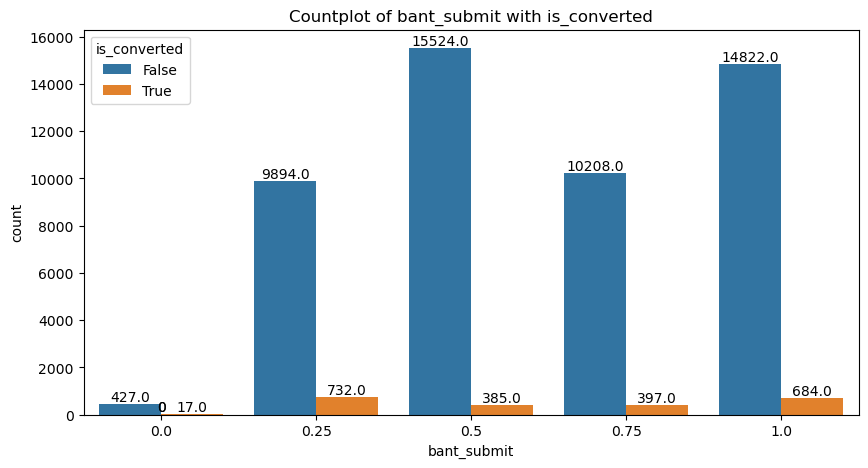

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# 'bant_submit'에 대한 각 카테고리의 개수를 'is_converted'에 따라 나누어 countplot 그리기
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='bant_submit', hue='is_converted', data=df_train)

# 각 막대 위에 count를 표시
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Countplot of bant_submit with is_converted')
plt.show()

In [20]:
correlation_value = df_train['bant_submit'].corr(df_train['is_converted'])
print(f"Correlation between 'bant_submit' and 'is_converted': {correlation_value}")

Correlation between 'bant_submit' and 'is_converted': -0.021393163956939517


### customer_country

In [21]:
df_train["customer_country"].value_counts()

customer_country
//India                       2827
/São Paulo/Brazil             1171
//United Kingdom               792
//                             646
//Philippines                  642
                              ... 
/Grevenmacher/Luxembourg         1
/Helsinki/Finland                1
/Auckland/New Zealand            1
/Merseyside/United Kingdom       1
/santa cruz bolivia/Peru         1
Name: count, Length: 14852, dtype: int64

In [22]:
df_train["customer_country"].nunique()

14852

In [23]:
df_test["customer_country"].value_counts()

customer_country
/  / Peru                           184
//United States                     160
Corporate /  /                      135
/  / Brazil                         132
/  / India                          116
                                   ... 
/ São Paulo/ Guarujá / Brazil         1
/ New York  / United States           1
/ Cortes / Honduras                   1
1233 20th St NW   / Washington /      1
/ Ongole  / India                     1
Name: count, Length: 2467, dtype: int64

### 3. business_unit

In [24]:
display(df_train["business_unit"].value_counts())
display(df_test["business_unit"].value_counts())
display(np.array(df_train["business_unit"].value_counts())/df_train.shape[0])
display(np.array(df_test["business_unit"].value_counts())/df_test.shape[0])

business_unit
ID    23407
AS    21775
IT     7908
Name: count, dtype: int64

business_unit
AS    2410
ID    2342
IT     519
Name: count, dtype: int64

array([0.44089282, 0.41015257, 0.14895461])

array([0.45721874, 0.44431797, 0.09846329])

In [25]:
df_train_t=df_train.copy()
from sklearn.preprocessing import LabelEncoder

# df_train_t의 'business_unit' 열을 레이블 인코딩
label_encoder = LabelEncoder()
df_train_t['business_unit'] = label_encoder.fit_transform(df_train_t['business_unit'])
df_train_t['business_unit'].corr(df_train_t['is_converted'])

0.09486411583685748

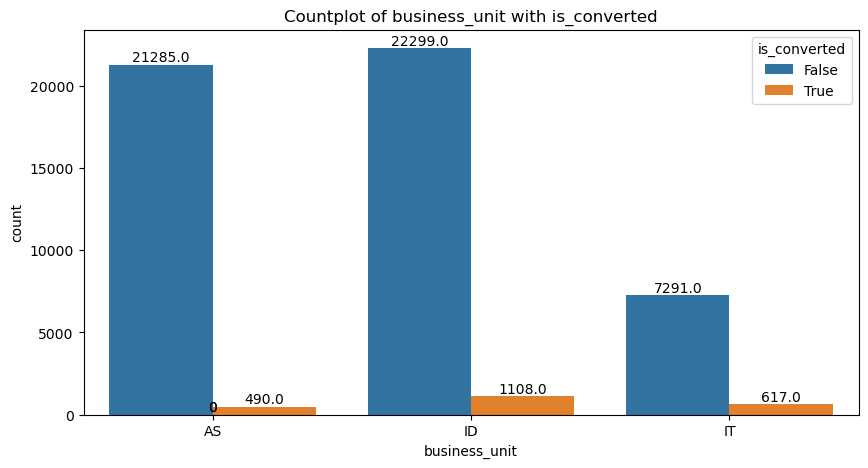

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# 'business_unit'에 대한 각 카테고리의 개수를 'is_converted'에 따라 나누어 countplot 그리기
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='business_unit', hue='is_converted', data=df_train)

# 각 막대 위에 count를 표시
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Countplot of business_unit with is_converted')
plt.show()

### 4. com_reg_ver_win_rate

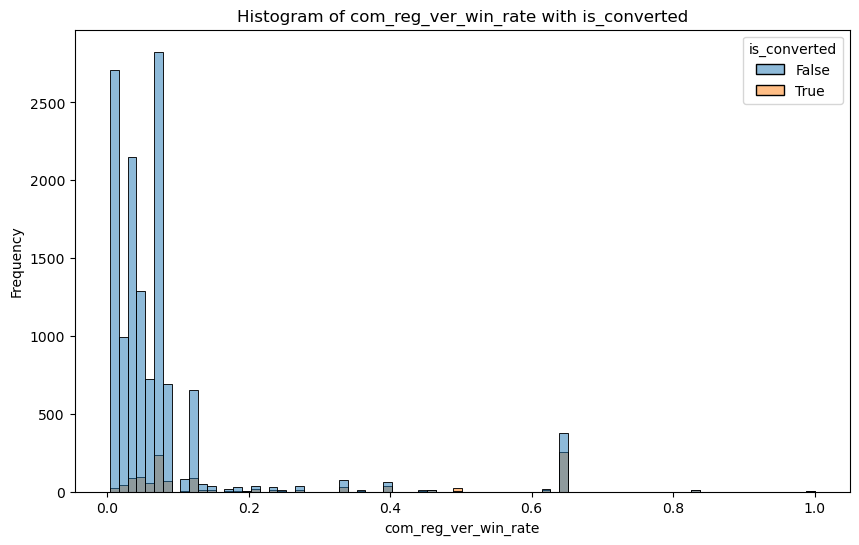

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# 'com_reg_ver_win_rate' 칼럼의 히스토그램 그리기
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='com_reg_ver_win_rate', hue='is_converted', bins=80)
plt.title('Histogram of com_reg_ver_win_rate with is_converted')
plt.xlabel('com_reg_ver_win_rate')
plt.ylabel('Frequency')
plt.show()

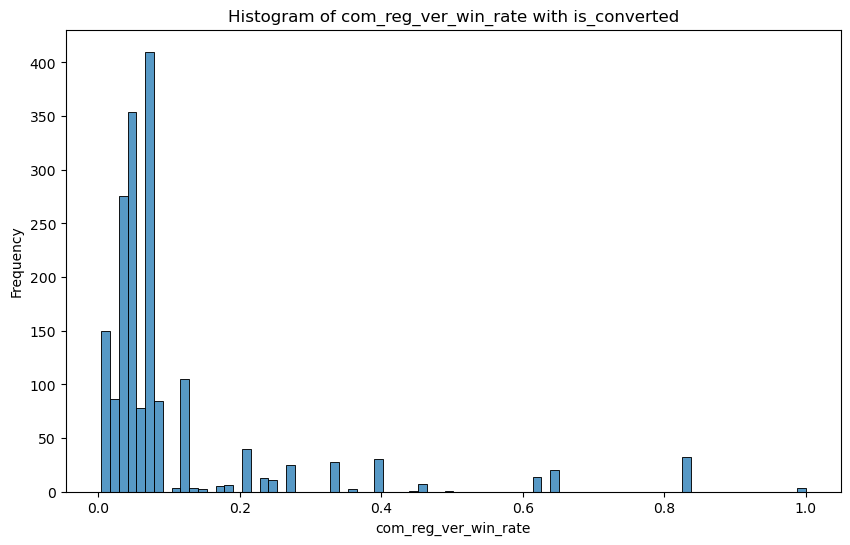

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# 'com_reg_ver_win_rate' 칼럼의 히스토그램 그리기
plt.figure(figsize=(10, 6))
sns.histplot(data=df_test, x='com_reg_ver_win_rate', bins=80)
plt.title('Histogram of com_reg_ver_win_rate with is_converted')
plt.xlabel('com_reg_ver_win_rate')
plt.ylabel('Frequency')
plt.show()

## 5. customer_idx

In [29]:
df_cus = df_train.groupby("customer_idx")["is_converted"].count().reset_index()
df_real_cus = df_train.groupby("customer_idx")["is_converted"].sum().reset_index()
df = pd.merge(df_cus, df_real_cus, on="customer_idx")
df["ratio"] = df["is_converted_y"] / df["is_converted_x"]
df = df.rename(columns={"is_converted_x": "query_cnt", "is_converted_y" : "converted_cnt"})
df = df[df["query_cnt"]>=2] 
df_train = pd.merge(df_train, df, on='customer_idx', how="left")
df_test = pd.merge(df_test, df, on='customer_idx', how="left")

In [30]:
pd.set_option("display.max_rows", 30)
df = df.sort_values(by=["ratio", "converted_cnt"], ascending=False)
df

,customer_idx,query_cnt,converted_cnt,ratio
6728,9324,14,14,1.0
7095,9857,11,11,1.0
6190,8582,8,8,1.0
7466,10350,7,7,1.0
9716,13440,6,6,1.0
...,...,...,...,...
34843,47432,2,0,0.0
34853,47444,2,0,0.0
34862,47453,2,0,0.0
34863,47454,2,0,0.0


In [31]:
df_cus = df_train.groupby("lead_owner")["is_converted"].count().reset_index()
df_real_cus = df_train.groupby("lead_owner")["is_converted"].sum().reset_index()
df = pd.merge(df_cus, df_real_cus, on="lead_owner")
df["lead_ratio"] = df["is_converted_y"] / df["is_converted_x"]
df = df.rename(columns={"is_converted_x": "lead_query_cnt", "is_converted_y" : "lead_converted_cnt"})
df = df.sort_values(by=["lead_ratio", "lead_converted_cnt"], ascending=False)
df = df[df["lead_query_cnt"]>=3] 
df_train = pd.merge(df_train, df, on='lead_owner', how="left")
df_test = pd.merge(df_test, df, on='lead_owner', how="left")
df

,lead_owner,lead_query_cnt,lead_converted_cnt,lead_ratio
147,152,36,36,1.0
142,147,28,28,1.0
349,367,11,11,1.0
424,448,8,8,1.0
853,996,7,7,1.0
...,...,...,...,...
893,1073,3,0,0.0
900,1080,5,0,0.0
910,1092,3,0,0.0
911,1093,3,0,0.0


In [32]:
df[df["lead_query_cnt"]>=2]

,lead_owner,lead_query_cnt,lead_converted_cnt,lead_ratio
147,152,36,36,1.0
142,147,28,28,1.0
349,367,11,11,1.0
424,448,8,8,1.0
853,996,7,7,1.0
...,...,...,...,...
893,1073,3,0,0.0
900,1080,5,0,0.0
910,1092,3,0,0.0
911,1093,3,0,0.0


## 캐글책

In [33]:
import pandas as pd
import numpy as np

train = pd.read_csv("train.csv")
test = pd.read_csv("submission.csv")

In [34]:
train = train[train["customer_idx"]!=25096]
train = train[(train["business_unit"] != "CM") & (train["business_unit"] != "Solution")]

In [35]:
train.drop_duplicates(inplace=True)

<Axes: >

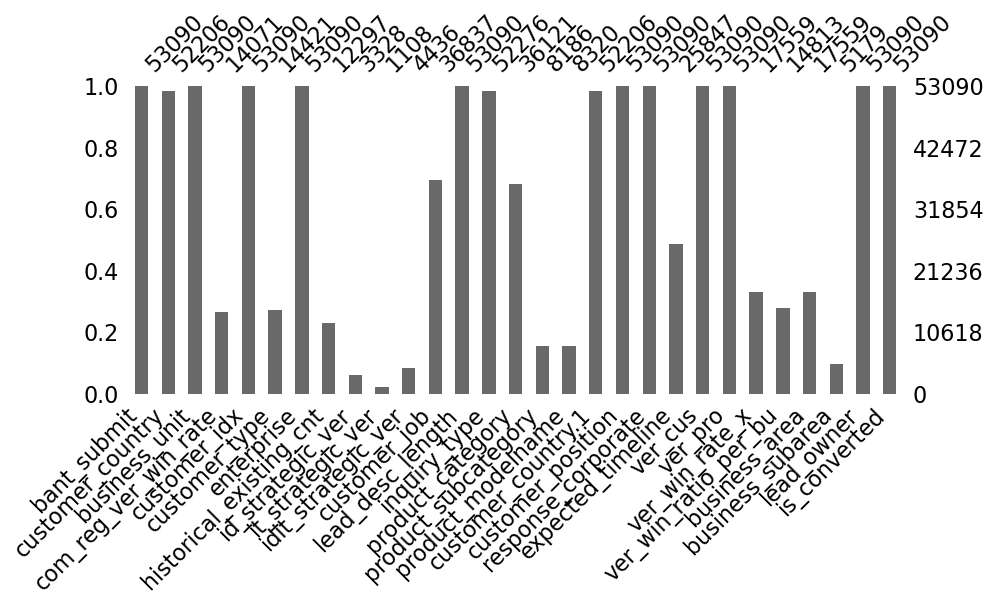

In [36]:
import missingno as msno

train_copy = train.copy().replace(-1, np.NaN)

msno.bar(df=train_copy, figsize=(10, 4))

In [37]:
def resumetable(df):
    print(f'데이터 세트 형상: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary['결측값 개수'] = (df == -1).sum().values # 피처별 -1 개수
    summary['고윳값 개수'] = df.nunique().values
    summary['데이터 종류'] = None
    for col in df.columns:
        if 'bin' in col or col == 'target':
            summary.loc[col, '데이터 종류'] = '이진형'
        elif 'cat' in col:
            summary.loc[col, '데이터 종류'] = '명목형'
        elif df[col].dtype == float:
            summary.loc[col, '데이터 종류'] = '연속형'
        elif df[col].dtype == int:
            summary.loc[col, '데이터 종류'] = '순서형'

    return summary

In [38]:
summary = resumetable(train)
summary

데이터 세트 형상: (53090, 29)


,데이터 타입,결측값 개수,고윳값 개수,데이터 종류
bant_submit,float64,0,5,연속형
customer_country,object,0,14852,None
business_unit,object,0,3,None
com_reg_ver_win_rate,float64,0,80,연속형
customer_idx,int64,0,34873,None
customer_type,object,0,33,None
enterprise,object,0,2,None
historical_existing_cnt,float64,0,134,연속형
id_strategic_ver,float64,0,1,연속형
it_strategic_ver,float64,0,1,연속형


In [39]:
import matplotlib.gridspec as gridspec

def plot_target_ratio_by_features(df, features, num_rows, num_cols, size=(12, 18)):
    # mpl.rc('font', size=9)
    plt.figure(figsize=size)
    grid = gridspec.GridSpec(num_rows, num_cols)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
    for idx, feature in enumerate(features) :
        ax = plt.subplot(grid[idx])
        sns.barplot(x=feature, y='is_converted', data=df, palette='Set2', ax=ax)

In [40]:
train = train.fillna(0)
test = test.fillna(0)

C:\Users\james\AppData\Local\Temp\ipykernel_6304\962834268.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='is_converted', data=df, palette='Set2', ax=ax)
C:\Users\james\AppData\Local\Temp\ipykernel_6304\962834268.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='is_converted', data=df, palette='Set2', ax=ax)
C:\Users\james\AppData\Local\Temp\ipykernel_6304\962834268.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='is_converted', data=df, palette='Set2', ax=ax)
C:\Users\james\AppData\Local

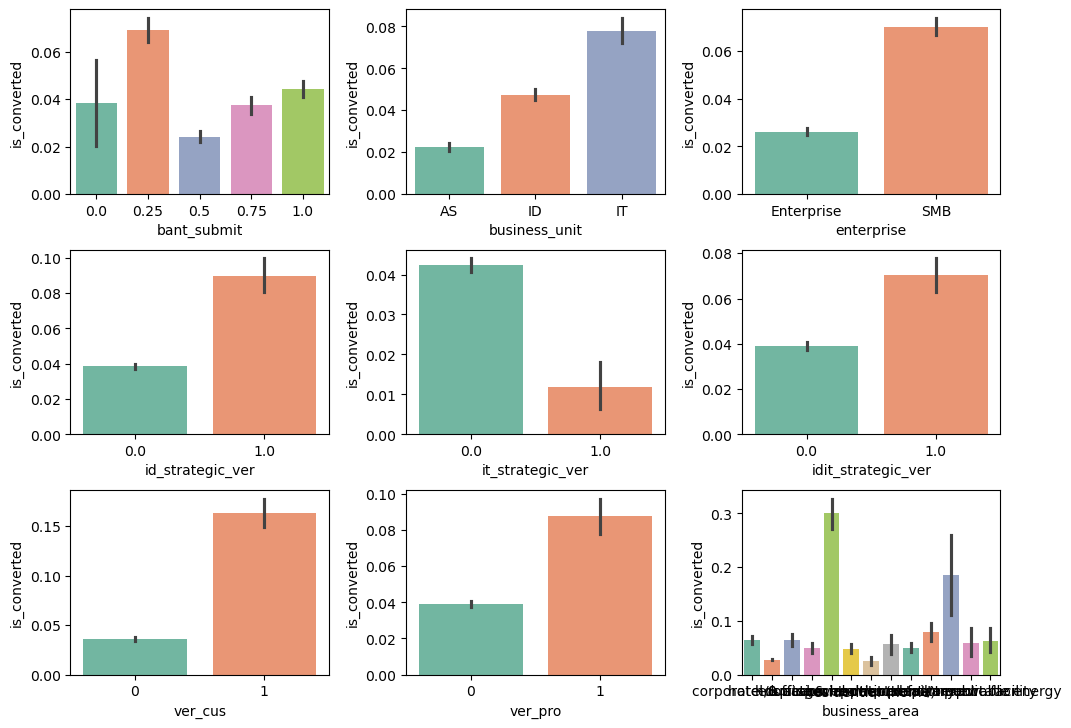

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

bin_features =  ["bant_submit", "business_unit", "enterprise", "id_strategic_ver", "it_strategic_ver", "idit_strategic_ver", "ver_cus", "ver_pro", "business_area"]
plot_target_ratio_by_features(train, bin_features, 6, 3)